## Import paketa i upoznavanje sa podacima

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from scipy import stats
%matplotlib inline
import warnings
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin
from sklearn.base import BaseEstimator, clone
warnings.filterwarnings('ignore')

In [2]:
train_df = pd.read_csv('input/train.tsv', delimiter='\t')
train_df.head()

,url,urlid,boilerplate,alchemy_category,alchemy_category_score,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,...,is_news,lengthyLinkDomain,linkwordscore,news_front_page,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
0,http://www.bloomberg.com/news/2010-12-23/ibm-p...,4042,"{""title"":""IBM Sees Holographic Calls Air Breat...",business,0.789131,2.055556,0.676471,0.205882,0.047059,0.023529,...,1,1,24,0,5424,170,8,0.152941,0.079130,0
1,http://www.popsci.com/technology/article/2012-...,8471,"{""title"":""The Fully Electronic Futuristic Star...",recreation,0.574147,3.677966,0.508021,0.288770,0.213904,0.144385,...,1,1,40,0,4973,187,9,0.181818,0.125448,1
2,http://www.menshealth.com/health/flu-fighting-...,1164,"{""title"":""Fruits that Fight the Flu fruits tha...",health,0.996526,2.382883,0.562016,0.321705,0.120155,0.042636,...,1,1,55,0,2240,258,11,0.166667,0.057613,1
3,http://www.dumblittleman.com/2007/12/10-foolpr...,6684,"{""title"":""10 Foolproof Tips for Better Sleep ""...",health,0.801248,1.543103,0.400000,0.100000,0.016667,0.000000,...,1,0,24,0,2737,120,5,0.041667,0.100858,1
4,http://bleacherreport.com/articles/1205138-the...,9006,"{""title"":""The 50 Coolest Jerseys You Didn t Kn...",sports,0.719157,2.676471,0.500000,0.222222,0.123457,0.043210,...,1,1,14,0,12032,162,10,0.098765,0.082569,0


StumbleUpon je sistem koji preporučuje relevantne, kvalitetne članke svojim korisnicima, na osnovu njihovih interesovanja. U pitanju su članci iz širokog spektra tematika. Neki od njih su relevatni samo nekoograničeno vreme, poput vesti i sezonskih recepata, a neki od njih privlače korisnike kroz duži period vremena. Ocene korisnika dosta doprinose tome da se zaključi da li je neki članak `evergreen` ili `ephemeral`, što pomaže sistemu preporuka da radi više u skladu sa interesovanjima korisnika. Ovo je za čoveka donekle intuitivni postupak, ali treba to znanje preneti i samom algoritmu. Dakle, u pitanju je problem binarne klasifikacije.

Kolone `alchemy_category` i `alchemy_category_score` su podaci dobijeni iz nekada javno dostupnog api-ja (dakle više nije dostupan).

`avglinksize` predstavlja prosečan broj reči koje postoje u linku.

`commonLinkRatio_n` predstavlja racio linka koji ima bar jednu zajedničku reč u linku sa n drugih linkova, i ukupnog broja linkova. 

`linkwordscore` је procenat reči na stranici koji se nalaze u okviru linka.

Ima i kolona koje se tiču odnosa različitih vrsta tagova (npr slika i linkova) u odnoszu na sve ostale tagove na stranici.

Imamo i kolonu `spelling_errors_ratio` koja označava sve one reči koje ne postoje na Vikipediji te se na takav način smatraju spelling greškom, dužina domenskog linka, da li je članak vest ili ne, i konačno, `label` sa oznakom da li je tekst `evergreen` ili ne.

In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7395 entries, 0 to 7394
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   url                             7395 non-null   object 
 1   urlid                           7395 non-null   int64  
 2   boilerplate                     7395 non-null   object 
 3   alchemy_category                7395 non-null   object 
 4   alchemy_category_score          7395 non-null   object 
 5   avglinksize                     7395 non-null   float64
 6   commonlinkratio_1               7395 non-null   float64
 7   commonlinkratio_2               7395 non-null   float64
 8   commonlinkratio_3               7395 non-null   float64
 9   commonlinkratio_4               7395 non-null   float64
 10  compression_ratio               7395 non-null   float64
 11  embed_ratio                     7395 non-null   float64
 12  framebased                      73

Imamo neke kolone koje vidimo da su tipa object iako su u suštini numeričke (poput `alchemy_category_score` ,`news_front_page` ,`is_news` ), što će kasnije biti konvertovano.Imamo kolonu `boilerplate` koja je json i od nje ćemo kasnije kreirati posebne kolone koje će se imenovati po ključevima tog jsona koji je trenutno interpretiran kao string.

In [4]:
train_df.urlid.nunique()

7395

Ni jedan članak se ne ponavlja, tj `url` i `urlid` jesu jedinstveni.

In [5]:
train_df['url']

0       http://www.bloomberg.com/news/2010-12-23/ibm-p...
1       http://www.popsci.com/technology/article/2012-...
2       http://www.menshealth.com/health/flu-fighting-...
3       http://www.dumblittleman.com/2007/12/10-foolpr...
4       http://bleacherreport.com/articles/1205138-the...
                              ...                        
7390    http://techcrunch.com/2010/09/08/kno-raises-46...
7391    http://www.uncoached.com/category/why-i-miss-c...
7392    http://eatthis.menshealth.com/slide/sweet-pota...
7393                            http://naturallyella.com/
7394    http://sportsillustrated.cnn.com/2011_swimsuit...
Name: url, Length: 7395, dtype: object

Nema smisla u ovom momentu raditi crawling stranica koje postoje u skupu podataka, s obzirom da dosta njih više i ne postoji (manuelna provera). Pored toga, imamo boilerplate kolonu koja se obuhvatila te podatke u momentu kada su bili relevantni. Stoga nam `url` kolona nije od koristi i biće obrisana u kasnijim fazama (kao i `urlid`).

In [6]:
train_df.is_news.value_counts()

1    4552
?    2843
Name: is_news, dtype: int64

Vidimo da se nedostajuće vrednosti mogu javiti i u obliku znaka pitanja, što će biti obrađeno kasnije.

In [7]:
train_df.alchemy_category.value_counts()

?                     2342
recreation            1229
arts_entertainment     941
business               880
health                 506
sports                 380
culture_politics       343
computer_internet      296
science_technology     289
gaming                  76
religion                72
law_crime               31
unknown                  6
weather                  4
Name: alchemy_category, dtype: int64

Vidimo da imamo nedostajuće vrednosti ali i neke kategorije koje su retke. Njih ćemo spajati sa drugim. 

In [8]:
train_df.is_news.describe()

count     7395
unique       2
top          1
freq      4552
Name: is_news, dtype: object

In [9]:
train_df.framebased.describe()

count    7395.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: framebased, dtype: float64

S obzirom da prethodna dva atributa imaju samo jednu vrednost, izbacujemo ga na početku.

In [10]:
train_df.drop(['urlid','url','is_news','framebased'],axis=1, inplace=True) 

## Izlazna varijabla

In [11]:
train_df.label.value_counts()

1    3796
0    3599
Name: label, dtype: int64

Naša target varijabla jeste label koja označava da li je naš članak evergreen ili nije.Naše klase su prilično ravnomerno raspoređene. To je olakšavajuća okolnost. U sklopu zahteva znamo da je metrika koja se optimizuje `roc-auc`.

## Nedostajuće vrednosti

In [12]:
train_df.isna().sum().sum()

0

Vidimo da ni jedna kolona nema nedostajuću vrednost na način na koji je prepoznat od strane pandas-a, ali to su već pomenuti znakovi pitanja na primer.

In [13]:
categorical_cols = list(train_df.select_dtypes(include='object').columns)
numerical_cols = list(train_df.select_dtypes(exclude='object').columns)

In [14]:
train_df[numerical_cols].describe()

,avglinksize,commonlinkratio_1,commonlinkratio_2,commonlinkratio_3,commonlinkratio_4,compression_ratio,embed_ratio,frameTagRatio,hasDomainLink,html_ratio,image_ratio,lengthyLinkDomain,linkwordscore,non_markup_alphanum_characters,numberOfLinks,numwords_in_url,parametrizedLinkRatio,spelling_errors_ratio,label
count,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000,7395.000000
mean,2.761823,0.468230,0.214080,0.092062,0.049262,2.255103,-0.103750,0.056423,0.021231,0.233778,0.275709,0.660311,30.077079,5716.598242,178.754564,4.960649,0.172864,0.101221,0.513320
std,8.619793,0.203133,0.146743,0.095978,0.072629,5.704313,0.306545,0.041446,0.144162,0.052487,1.919320,0.473636,20.393101,8875.432430,179.466198,3.233111,0.183286,0.079231,0.499856
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.045564,-1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,1.602062,0.340370,0.105263,0.022222,0.000000,0.442616,0.000000,0.028502,0.000000,0.201061,0.025900,0.000000,14.000000,1579.000000,82.000000,3.000000,0.040984,0.068739,0.000000
50%,2.088235,0.481481,0.202454,0.068627,0.022222,0.483680,0.000000,0.045775,0.000000,0.230564,0.083051,1.000000,25.000000,3500.000000,139.000000,5.000000,0.113402,0.089312,1.000000
75%,2.627451,0.616604,0.300000,0.133333,0.065065,0.578227,0.000000,0.073459,0.000000,0.260770,0.236700,1.000000,43.000000,6377.000000,222.000000,7.000000,0.241299,0.112376,1.000000
max,363.000000,1.000000,1.000000,0.980392,0.980392,21.000000,0.250000,0.444444,1.000000,0.716883,113.333333,1.000000,100.000000,207952.000000,4997.000000,22.000000,1.000000,1.000000,1.000000


Sve preostale kolone imaju standardnu devijaciju koja se razlikuje od nule.

Jedna od odudarajućih vrednosti jeste `compression_ratio`.

If the data has low redundancy to start with, for instance, the archive contains images files in a format that is compressed natively (gif, jpg, png, ...), then gzip may add not further compression at all. For binary files like program executables you might see up to 2:1 compression, for plain text, HTML or other markups 3:1 or 4:1 or more is not unlikely. You might see 10:1 in some cases but the ~1030:1 seen with a file filled with a single symbol is something you are not going to see outside similarly artificial circumstances.

Vidimo i da broj linkova može dosta do odstupa. Pri tome, i prosečna dužina linka ima takođe, kao i na primer `non_markup_alphanum_characters`,`image_ratio`... Ova odstupanja se nalaze uglavnom nakon 75. percentila, te stoga tu verovatno postoje i outlieri koji će kasnije biti izbačeni. S obzirom da postoji razlika u rasponu, bilo bi najbolje standardizovati podatke.  

In [15]:
train_df.replace(to_replace='?', value=np.nan, inplace=True)
pd.to_numeric(train_df['news_front_page'],downcast='integer', errors='coerce')
pd.to_numeric(train_df['alchemy_category_score'],downcast='float', errors='coerce')

0       0.789131
1       0.574147
2       0.996526
3       0.801248
4       0.719157
          ...   
7390    0.651067
7391    0.141920
7392    0.196273
7393    0.617876
7394         NaN
Name: alchemy_category_score, Length: 7395, dtype: float32

In [16]:
categorical_cols = list(train_df.select_dtypes(include='object').columns)
numerical_cols = list(train_df.select_dtypes(exclude='object').columns)

## Univarijantna analiza

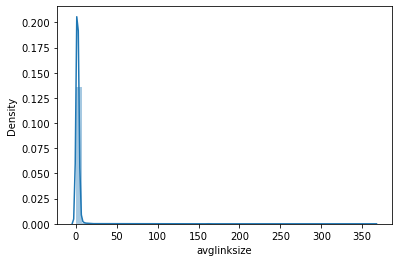

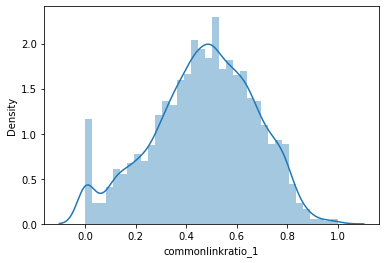

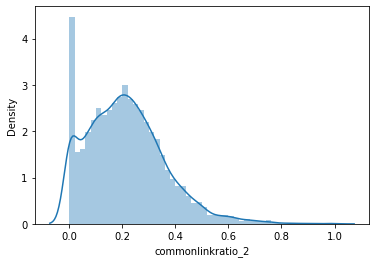

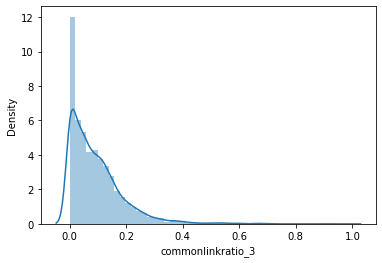

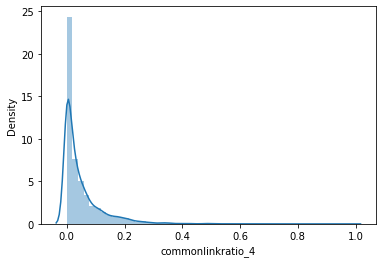

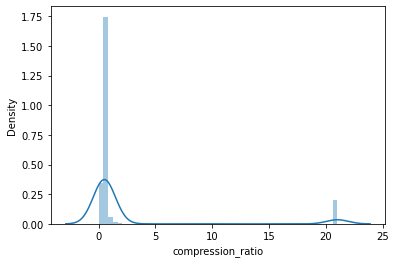

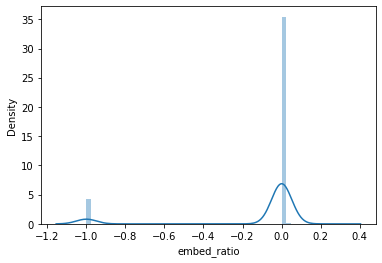

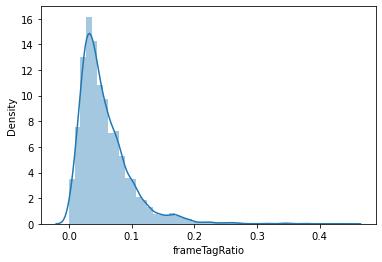

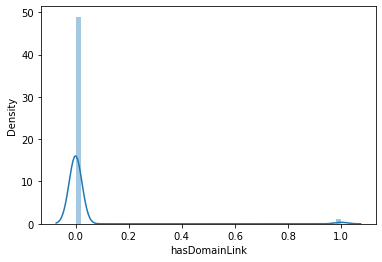

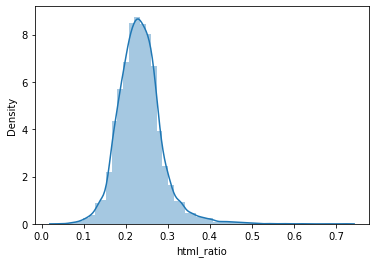

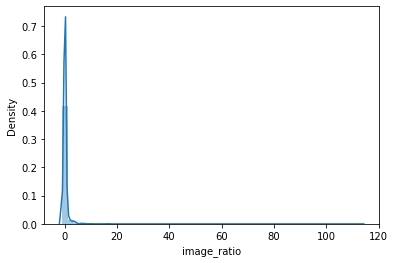

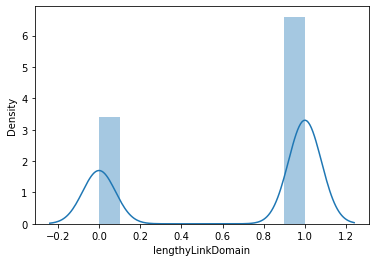

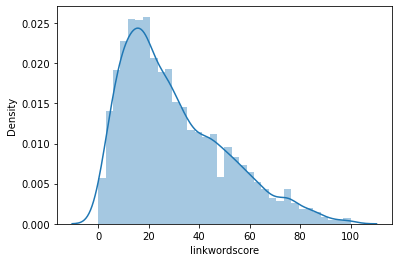

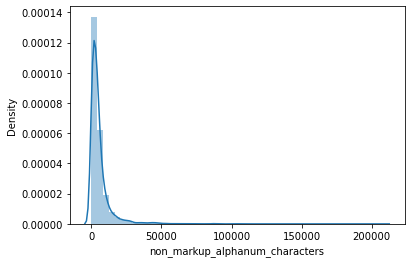

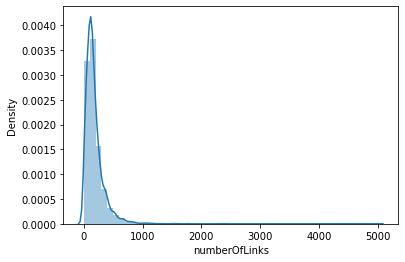

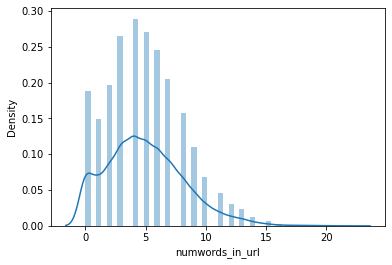

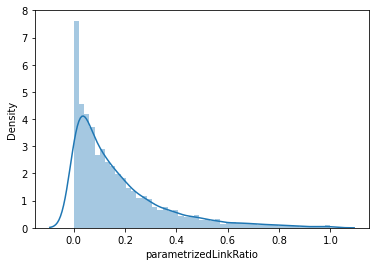

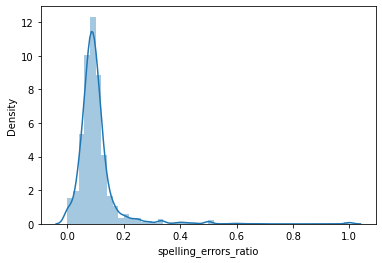

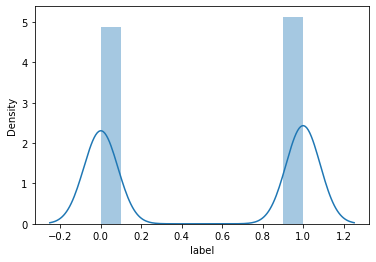

In [17]:
for feature in numerical_cols:
    sns.distplot(x = train_df[feature])
    plt.xlabel(feature)
    plt.show()

Kod nekih atributa pronađena je i bimodalna distribucija, poput lengthyLinkDomain kolone, i potencijalno embed_ratio, a samim tim i compression_ratio jer su oni u negativnoj korelaciji. Vidimo različite oblike distribucije i raspone skala, tako da nas svakako čeka standardizacija.

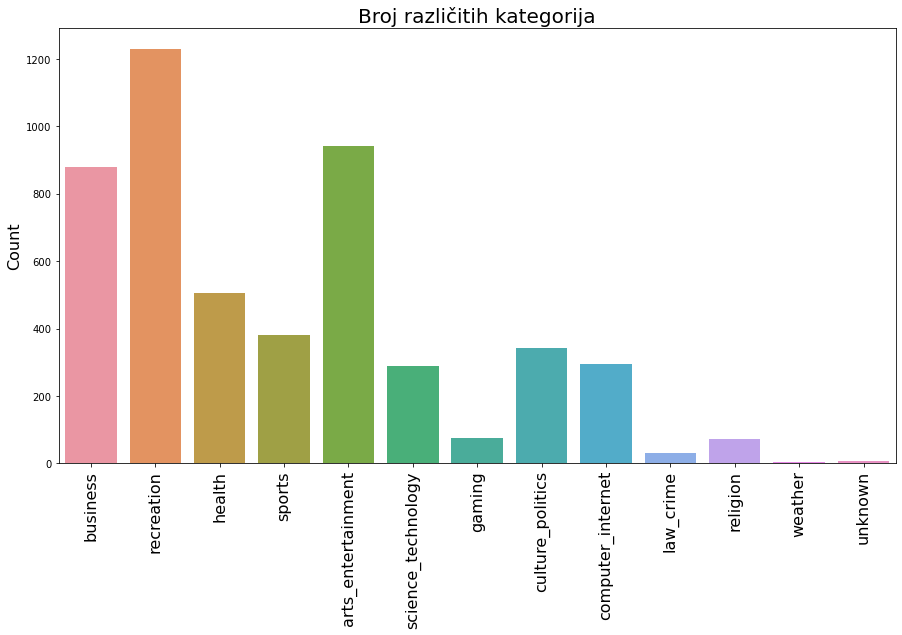

In [18]:
plt.figure(figsize=(15,8))
sns.countplot(x='alchemy_category', data=train_df)
plt.xlabel('', fontsize=16)
plt.title('Broj različitih kategorija',fontsize=20)
plt.ylabel('Count', fontsize=16)
plt.xticks(rotation='vertical',fontsize=16)
plt.show()

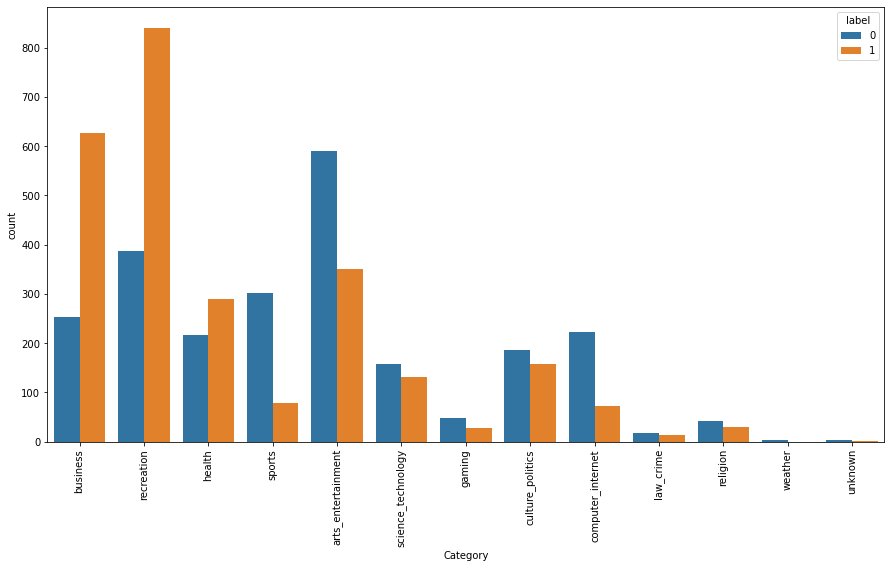

In [19]:
plt.figure(figsize=(15,8))
sns.countplot(x=train_df['alchemy_category'],hue=train_df['label']);
plt.xlabel('Category');
plt.xticks(rotation=90);

Ovo podržava ono što je gore već bilo navedeno, da imamo nešto neravnomernije vrednosti za ove kategorije, te ćemo neke koje se ređe pojavljuju spojiti u jednu. Vidimo da su u domenu biznisa i rekreacije većinski u pitanju evergreen članci, dok su na primer oni koji se tiču sporta ili modernih tehnologija, skloni prolaznosti.

## Interakcije atributa

<AxesSubplot:>

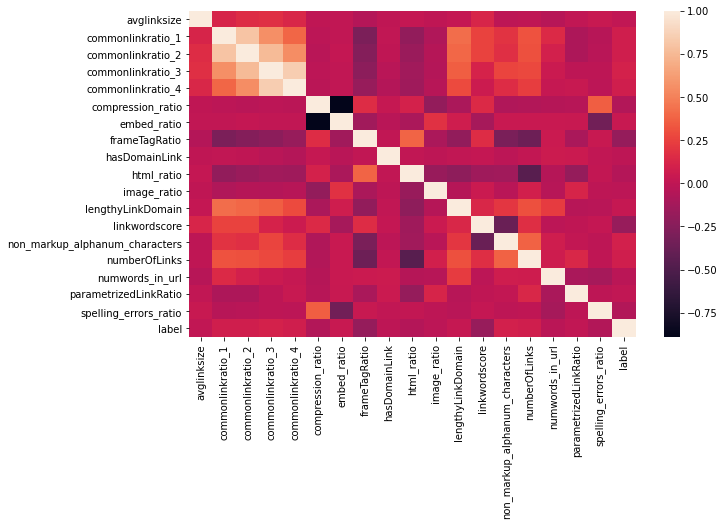

In [20]:
plt.figure(figsize=(10, 6))
sns.heatmap(train_df.corr())

Uglavnom su to neke pozitivne korelacije, osim logično compression ratio i embed ratio. Interesantno je da html ratio i number of links takođe imaju primetnu negativnu korelaciju. Za neke korelacije nema vrednosti.

Text(0.5, 0, 'label')

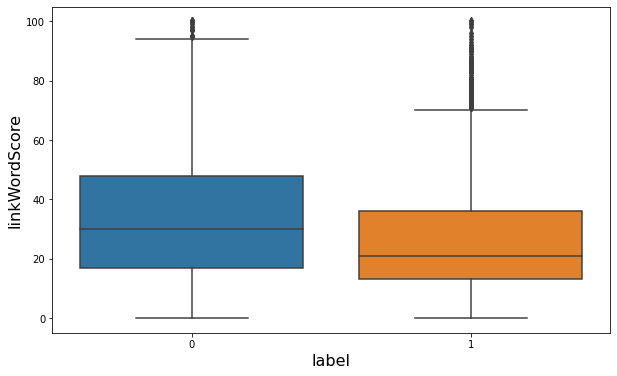

In [21]:
plt.figure(figsize=(10,6))
sns.boxplot(x='label', y="linkwordscore", data=train_df)
plt.ylabel('linkWordScore', fontsize=16)
plt.xlabel('label', fontsize=16)

Evergreen članci imaju nešto manji broj reči u okviru linkova u odnosu na ephemeral članke.

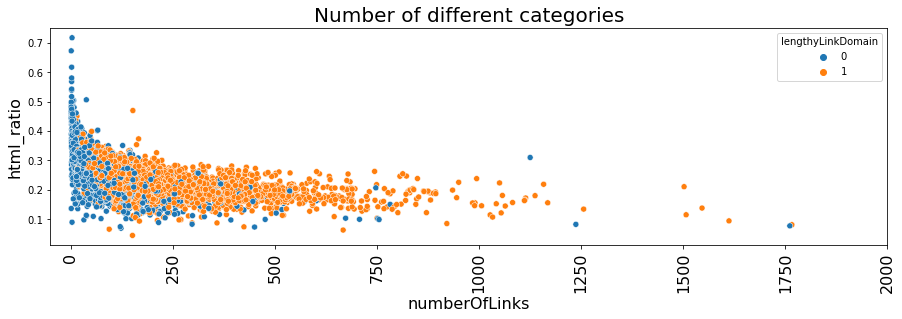

In [22]:
plt.figure(figsize=(15,4))
sns.scatterplot(x='numberOfLinks',y='html_ratio',hue='lengthyLinkDomain',data=train_df)
plt.ylabel('html_ratio', fontsize=16)
plt.title('Number of different categories',fontsize=20)
plt.xlabel('numberOfLinks', fontsize=16)
plt.xticks(rotation='vertical',fontsize=16)
plt.xlim([-50,2000])
plt.show()

U kombinaciji sa hue='label' nije identifikovana ni jedna specijalna veza. Verovatno se prava razlika vidi u koloni kojoj u ovom trenutku nemamo pristup jer njena obrada sledi u narednim delovima, a to je `boilerplate`. To donekle i ima smisla. Mi procenjuje neki članak najvećim delom po njegovom sadržaju, a ne broju spelling grešaka ili nekakvoj kompresiji na sajtu. Takve stvari možda imaju više smisla ukoliko bi se ocenjivao user experience tokom čitanja, kada bi na primer to bio neki rejting sistem ovih članaka, a to svakako nije problem koji se pred nama nalazi.